# Vector-Quantized Variational Autoencoders

**Description**: Training a VQ-VAE for image reconstruction and sampling the codebook for image generation.

In this notebook, we construct a **Vector Quantized Variational Autoencoder** (VQ-VAE). Unlike traditional VAEs, where the latent space is continuous and sampled from a Gaussian distribution, VQ-VAEs adopt a discrete latent space, simplifying the optimization process. This is achieved by managing a discrete set known as a **codebook**. The creation of this codebook involves discretizing the space between continuous embeddings and the encoded outputs. These discrete code words are subsequently input into the decoder, which is trained to produce reconstructed samples.


In [1]:
!pip install -q tensorflow-probability

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

## VectorQuantizer layer


Initially, we create a custom layer for the vector quantizer, positioned between the encoder and decoder. Consider an encoder output with dimensions `(batch_size, height, width, num_filters)`. The vector quantizer flattens this output while preserving the num_filters dimension, resulting in a shape of `(batch_size * height * width, num_filters)`. This flattening is done to treat the total number of filters as the size for the latent embeddings.

To establish a codebook, we initialize an embedding table. The L2-normalized distance is computed between the flattened encoder outputs and the code words in this codebook. The code that minimizes the distance is chosen, and one-hot encoding is applied for quantization. Consequently, the code with the minimum distance to the corresponding encoder output is assigned as one, while the other codes are set to zero.

Given that the quantization process lacks differentiability, we introduce a straight-through estimator between the decoder and encoder. This ensures that the decoder gradients directly influence the encoder. Since both the encoder and decoder share the same channel space, the gradients from the decoder remain meaningful to the encoder.

In [3]:

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices


**Straight Through Estimation**:

The straight-through estimation is done by this line of code: `quantized = x + tf.stop_gradient(quantized - x)`. During backpropagation, `(quantized - x)` won't be included in the computation graph and the gradients obtained for `quantized` will be copied for `inputs`.

## Encoder and decoder

To ensure compatibility with the MNIST dataset, the sizes of the encoder and the decoder are kept small.

For the encoder and decoder layers in the quantization architecture, activations other than ReLU might be problematic. Layers activated with Leaky ReLU, for instance, have demonstrated challenges during training, leading to occasional spikes in loss that the model struggles to overcome.

In [4]:

def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


## Standalone VQ-VAE model

In [5]:

def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQu  (None, 7, 7, 16)          1024      
 antizer)                                                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48913 (191.07 KB)
Trainable params: 48913 (191.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The output channels of the encoder must match the `latent_dim` for the vector quantizer.

## Training loop inside `VQVAETrainer`

In [6]:

class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


## Loading and preprocessing the MNIST dataset

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

11490434/11490434 [==============================] - 0s 0us/step


## Training the VQ-VAE model

In [8]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 36s 73ms/step - loss: 2.2000 - reconstruction_loss: 0.3488 - vqvae_loss: 1.5232
Epoch 2/30
469/469 [==============================] - 34s 73ms/step - loss: 2.3435 - reconstruction_loss: 0.1488 - vqvae_loss: 2.1850
Epoch 3/30
469/469 [==============================] - 34s 72ms/step - loss: 1.0313 - reconstruction_loss: 0.1233 - vqvae_loss: 0.9012
Epoch 4/30
469/469 [==============================] - 34s 72ms/step - loss: 0.5982 - reconstruction_loss: 0.1025 - vqvae_loss: 0.4913
Epoch 5/30
469/469 [==============================] - 34s 72ms/step - loss: 0.4447 - reconstruction_loss: 0.0911 - vqvae_loss: 0.3515
Epoch 6/30
469/469 [==============================] - 34s 72ms/step - loss: 0.3823 - reconstruction_loss: 0.0846 - vqvae_loss: 0.2961
Epoch 7/30
469/469 [==============================] - 34s 72ms/step - loss: 0.3494 - reconstruction_loss: 0.0792 - vqvae_loss: 0.2689
Epoch 8/30
469/469 [==============================] - 34s 72ms

## Reconstruction results on the test set

1/1 [==============================] - 0s 197ms/step


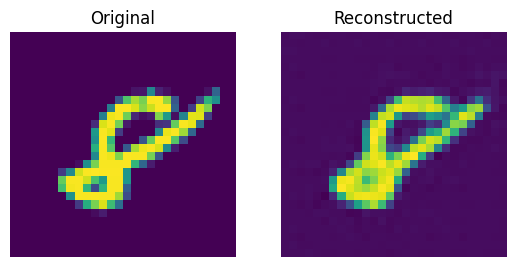

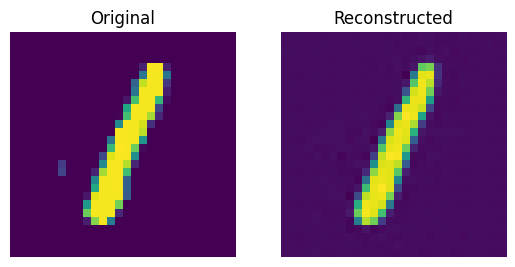

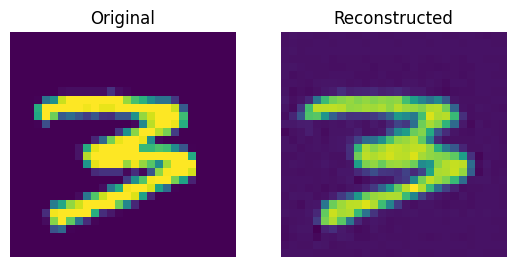

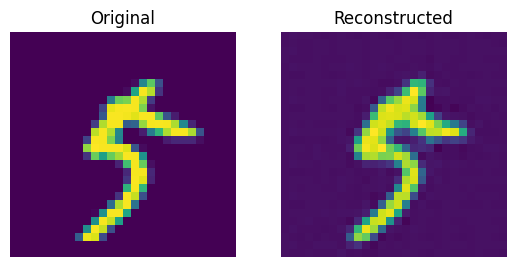

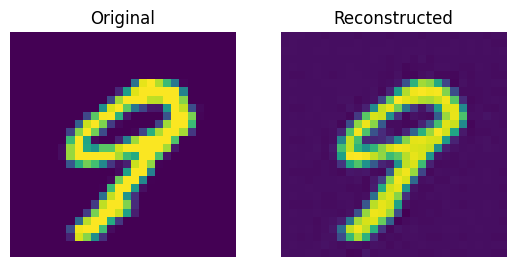

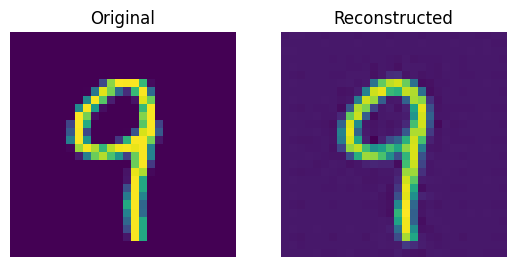

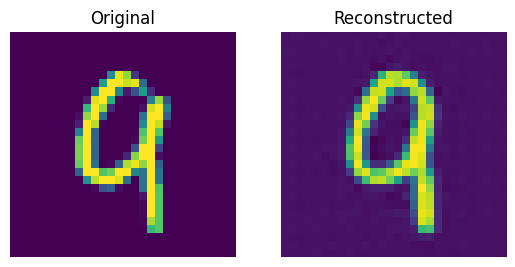

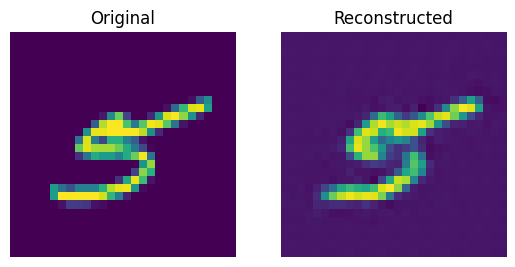

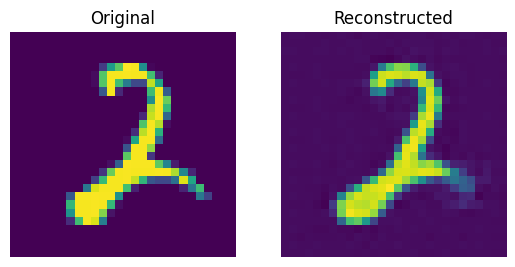

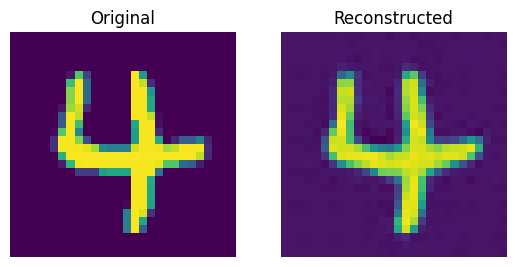

In [9]:

def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

The number of embeddings and the dimensions of the embeddings can be tuned as hyperparameters and the difference in results can be observed.

## Plotting the codebook 

1/1 [==============================] - 0s 62ms/step


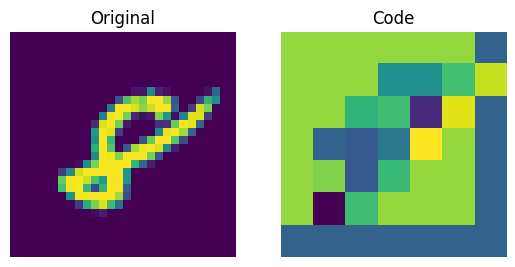

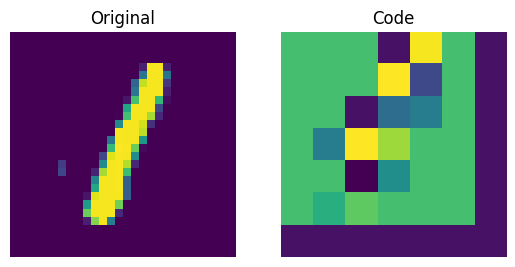

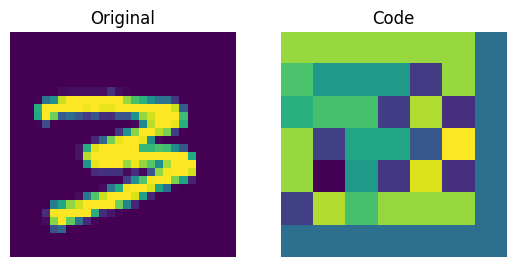

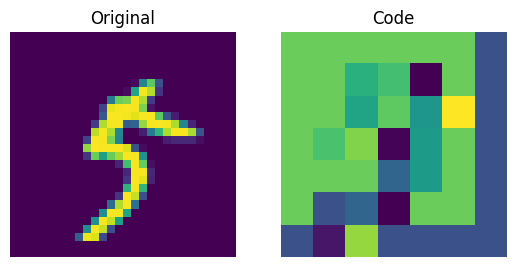

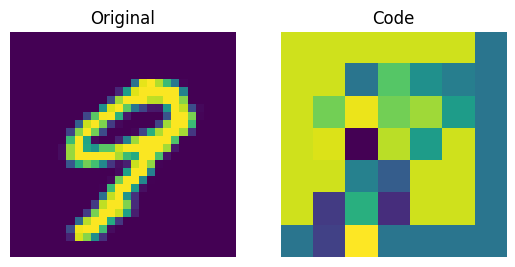

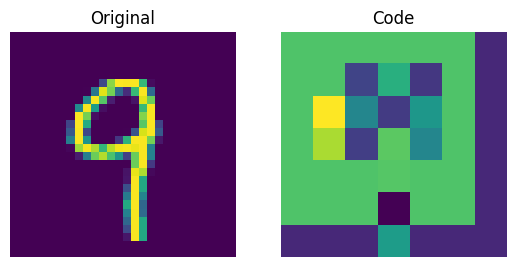

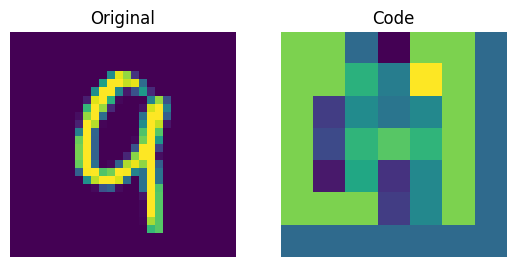

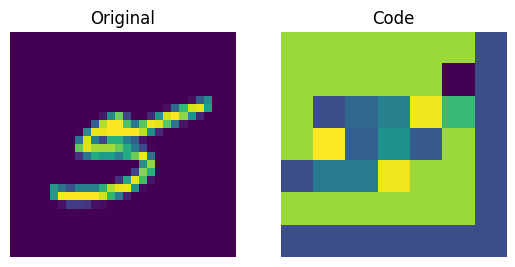

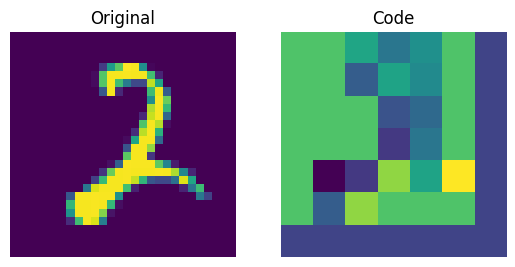

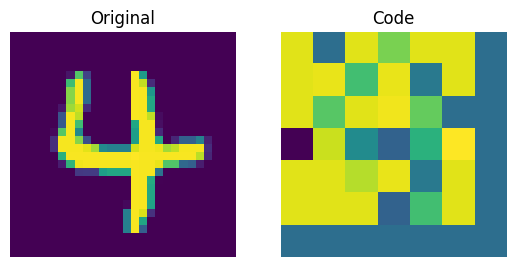

In [10]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

The plot presented above illustrates that the discrete codes effectively capture certain patterns within the dataset. Now, the question arises: how do we extract samples from this codebook to generate new images? Given the discrete nature of these codes and the imposition of a categorical distribution, direct generation of meaningful content is not feasible. To achieve this, we need to generate probable sequences of codes that can be fed into the decoder.

To address this challenge, we employ a PixelCNN to train these codes, transforming them into potent priors for generating novel examples. PixelCNN functions as an autoregressive generative model, where outputs depend on prior ones. It generates an image pixel by pixel. However, in this specific scenario, its role is to produce codebook indices rather than pixels directly. The trained VQ-VAE decoder is then employed to map the indices generated by the PixelCNN back into the pixel space.

## PixelCNN hyperparameters

In [11]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")

Input shape of the PixelCNN: (7, 7)


This input shape signifies the reduction in resolution carried out by the encoder. Employing "same" padding ensures an exact halving of the "resolution" for each stride-2 convolution layer in the output shape. Consequently, with these two layers, the resulting encoder output tensor becomes 7x7 along axes 2 and 3, where the first axis denotes the batch size, and the last axis represents the codebook embedding size. Given that the quantization layer maps these 7x7 tensors to codebook indices, the PixelCNN must align its input shape with these output layer axis sizes. The primary role of the PixelCNN in this architecture is to generate probable 7x7 arrangements of codebook indices.

This shape is a critical consideration in larger image domains, alongside the codebook sizes. Since PixelCNN operates in an autoregressive manner, it sequentially processes each codebook index to generate new images. Each stride-2 (or more accurately, stride (2, 2)) convolution layer divides the time required for image generation by four. However, there exists a potential lower limit: if the number of codes for reconstructing the image is too small, the decoder lacks sufficient information to represent the image's level of detail, resulting in diminished output quality. This limitation can be mitigated to some extent by employing a larger codebook. As the autoregressive process relies on codebook indices, the performance impact of using a larger codebook is less significant, considering the quicker lookup time for a larger-sized code compared to iterating over a larger sequence of codebook indices. Nevertheless, the codebook size does affect the batch size that can traverse the image generation process. Determining the optimal balance for this trade-off may necessitate adjustments to the architecture and could vary across different datasets.

## PixelCNN model


In [12]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super().__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])


pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = keras.layers.Conv2D(
    filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="valid"
)(x)

pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 128)         0         
                                                                 
 pixel_conv_layer (PixelCon  (None, 7, 7, 128)         802944    
 vLayer)                                                         
                                                                 
 residual_block (ResidualBl  (None, 7, 7, 128)         98624     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 7, 7, 128)         98624     
 Block)                                                          
                                                         

## Prepare data to train the PixelCNN

The training process for the PixelCNN involves learning a categorical distribution for the discrete codes. Initially, we generate code indices using the recently trained encoder and vector quantizer. The objective during training is to minimize the cross-entropy loss between these indices and the PixelCNN outputs. In this context, the number of categories corresponds to the embeddings in our codebook (in our case, 128). Notably, the PixelCNN model is designed to learn a distribution, deviating from the goal of minimizing L1/L2 loss. It is this learned distribution that endows the PixelCNN with its generative capabilities.

In [13]:
# Generate the codebook indices.
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

1875/1875 [==============================] - 5s 3ms/step
Shape of the training data for PixelCNN: (60000, 7, 7)


## PixelCNN training

In [14]:
pixel_cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
pixel_cnn.fit(
    x=codebook_indices,
    y=codebook_indices,
    batch_size=64,
    epochs=30,
    validation_split=0.1,
)

Epoch 1/30
844/844 [==============================] - 137s 160ms/step - loss: 1.5628 - accuracy: 0.6105 - val_loss: 1.1910 - val_accuracy: 0.6569
Epoch 2/30
844/844 [==============================] - 135s 159ms/step - loss: 1.1373 - accuracy: 0.6652 - val_loss: 1.1092 - val_accuracy: 0.6703
Epoch 3/30
844/844 [==============================] - 134s 158ms/step - loss: 1.0826 - accuracy: 0.6751 - val_loss: 1.0783 - val_accuracy: 0.6755
Epoch 4/30
844/844 [==============================] - 133s 158ms/step - loss: 1.0530 - accuracy: 0.6805 - val_loss: 1.0586 - val_accuracy: 0.6788
Epoch 5/30
844/844 [==============================] - 137s 163ms/step - loss: 1.0336 - accuracy: 0.6843 - val_loss: 1.0476 - val_accuracy: 0.6812
Epoch 6/30
844/844 [==============================] - 135s 160ms/step - loss: 1.0195 - accuracy: 0.6871 - val_loss: 1.0444 - val_accuracy: 0.6808
Epoch 7/30
844/844 [==============================] - 134s 158ms/step - loss: 1.0082 - accuracy: 0.6895 - val_loss: 1.0357 -

We can improve these scores with more training and hyperparameter tuning.

## Codebook sampling

Now that our PixelCNN is trained, we can sample distinct codes from its outputs and pass
them to our decoder to generate novel images.

In [15]:
# Create a mini sampler model.
inputs = layers.Input(shape=pixel_cnn.input_shape[1:])
outputs = pixel_cnn(inputs, training=False)
categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
outputs = categorical_layer(outputs)
sampler = keras.Model(inputs, outputs)

We now construct a prior to generate images. Here, we generate 10 images.

In [16]:
# Create an empty array of priors.
batch = 10
priors = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols = priors.shape

# Iterate over the priors because generation has to be done sequentially pixel by pixel.
for row in range(rows):
    for col in range(cols):
        # Feed the whole array and retrieving the pixel value probabilities for the next
        # pixel.
        probs = sampler.predict(priors)
        # Use the probabilities to pick pixel values and append the values to the priors.
        priors[:, row, col] = probs[:, row, col]

print(f"Prior shape: {priors.shape}")

1/1 [==============================] - 0s 30ms/step
Prior shape: (10, 7, 7)


We can now use our decoder to generate the images.

1/1 [==============================] - 0s 97ms/step


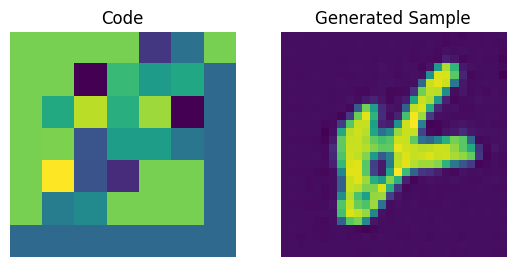

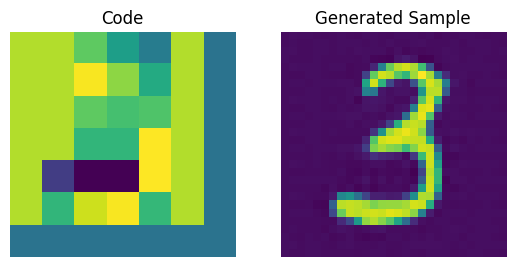

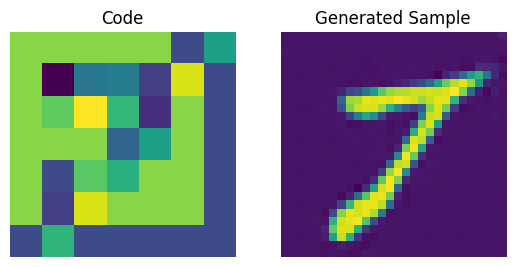

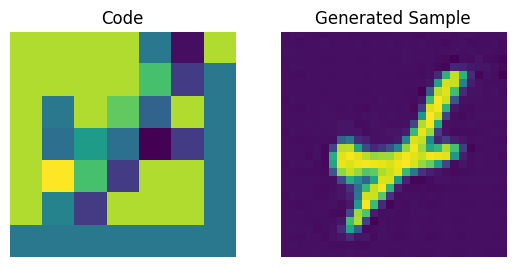

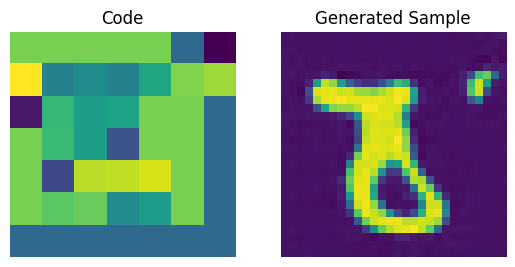

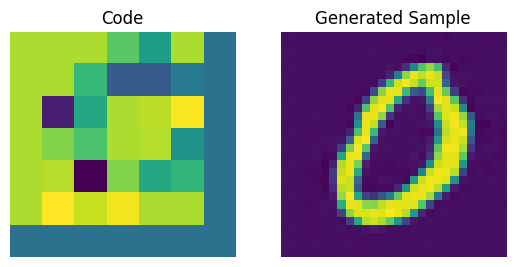

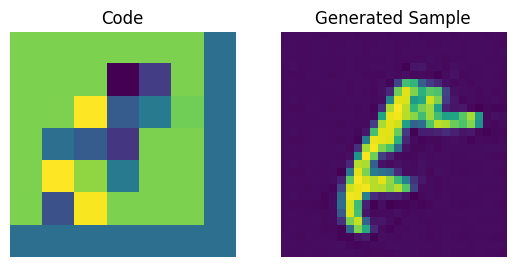

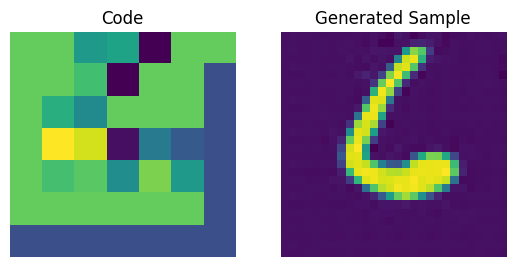

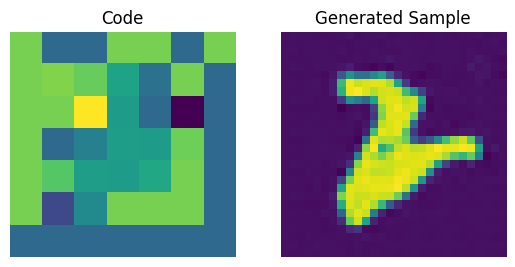

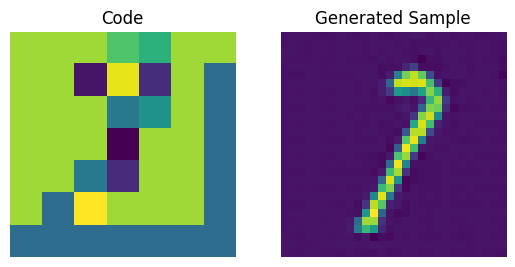

In [17]:
# Perform an embedding lookup.
pretrained_embeddings = quantizer.embeddings
priors_ohe = tf.one_hot(priors.astype("int32"), vqvae_trainer.num_embeddings).numpy()
quantized = tf.matmul(
    priors_ohe.astype("float32"), pretrained_embeddings, transpose_b=True
)
quantized = tf.reshape(quantized, (-1, *(encoded_outputs.shape[1:])))

# Generate novel images.
decoder = vqvae_trainer.vqvae.get_layer("decoder")
generated_samples = decoder.predict(quantized)

for i in range(batch):
    plt.subplot(1, 2, 1)
    plt.imshow(priors[i])
    plt.title("Code")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(generated_samples[i].squeeze() + 0.5)
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

We can enhance the quality of these generated samples by tweaking the PixelCNN model.